In [1]:
from IPython.display import HTML

HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
                $('button#code-toggle').text('Show Code');
            } else {
                $('div.input').show();
                $('button#code-toggle').text('Hide Code');
            }
            code_show = !code_show
        }
    </script>

    <button id="code-toggle" onclick="javascript:code_toggle()">
        Hide Code
    </button>
''')

# Challenge: Iterate and Evaluate Your Classifier

In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data_path = ('sentiments/amazon_cells_labelled.txt')
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['text', 'Positive']

df.head()

,text,Positive
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [3]:
from collections import Counter
import re

common_words = ['a', 'about', 'all', 'also', 'am', 'an', 'and', 'are', 'as', 'at', 'be', 'because', 'by', 'can', 'did', 'do', 'does', 'even', 'for', 'from', 'get', 'had', 'has', 'have', 'having', 'i', "if", "i'm", "i've", 'in', 'is', 'it', "it's", 'its', 'me', 'my', 'of', 'on', 'one', 'or', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'to', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'will', 'with', 'within', 'you', 'your']
domain_specific_words = ['amazon', 'audio', 'batteries', 'battery', 'bluetooth', 'buttons', 'camera', 'car', 'cars', 'charger', 'device', 'ear', 'ears', 'earset', 'headphones', 'headset', 'jabra', 'jawbone', 'motorola', 'nokia', 'phone', 'plug', 'samsung', 'software', 'sound', 'verizon']
all_words = []
for row in df.iterrows():
    sentence = row[1]['text'].lower()
    sentence = re.sub("[^a-zA-Z' ]+", '', sentence)
    words = sentence.split()
    for word in words:
        if len(word) > 0 and word not in common_words and word not in domain_specific_words:
            all_words.append(word)

counts = Counter(all_words)
keywords = [k for k, v in counts.items() if v > 15]

## Iteration 1

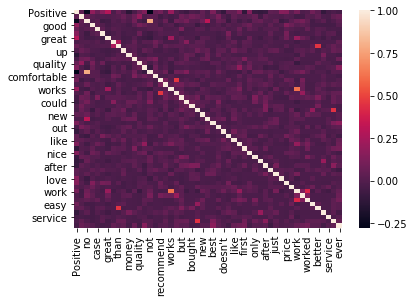

BASELINE: 78.7% accuracy
Tried removing "so": -0.2% in accuracy
Tried removing "no": 0.2% in accuracy
Tried removing "good": -1.2% in accuracy
Tried removing "case": -0.3% in accuracy
Tried removing "excellent": -0.9% in accuracy
Tried removing "great": -3.1% in accuracy
Tried removing "more": 0.0% in accuracy
Tried removing "than": -0.6% in accuracy
Tried removing "up": 0.0% in accuracy
Tried removing "money": -0.2% in accuracy
Tried removing "time": 0.2% in accuracy
Tried removing "quality": 0.5% in accuracy
Tried removing "very": -1.2% in accuracy
Tried removing "not": 0.2% in accuracy
Tried removing "comfortable": -0.3% in accuracy
Tried removing "recommend": -1.0% in accuracy
Tried removing "any": 0.0% in accuracy
Tried removing "works": -0.1% in accuracy
Tried removing "would": 0.0% in accuracy
Tried removing "but": -0.1% in accuracy
Tried removing "could": 0.2% in accuracy
Tried removing "bought": 0.2% in accuracy
Tried removing "use": 0.2% in accuracy
Tried removing "new": -0.1

81.0

In [4]:
for key in keywords:
    df[str(key)] = df.text.str.contains(str(key), case=False)

sns.heatmap(df.corr())
plt.show()

data = df[keywords]
target = df['Positive']

bnb = BernoulliNB()
bnb.fit(data, target)

my_predictions = bnb.predict(data)
baseline = ((target == my_predictions).sum()/data.shape[0]) * 100
print('BASELINE: {}% accuracy'.format(baseline))

def train_on_original_data(keywords):
    for key in keywords:
        negators = ['no', 'not', "n't"]
        for negator in negators:
            df[str(key)] = df.text.str.contains(str(key), case=False) 
#         negators = ['no', 'not', "n't"]
#         for negator in negators:
#             if df.text.str.contains((negator + ' ' + str(key)), case=False):
#                 df[str(key)] = False

    data = df[keywords]
    target = df['Positive']

    bnb = BernoulliNB()
    bnb.fit(data, target)

    my_predictions = bnb.predict(data)
    return ((target == my_predictions).sum()/data.shape[0]) * 100

def backwards_pass(keywords):
    answer_key = {}
    for keyword in keywords:
        test_keywords = list(keywords)
        test_keywords.remove(keyword)
        percentage = train_on_original_data(test_keywords)
        answer_key[keyword] = percentage
        print('Tried removing "{}": {}% in accuracy'.format(keyword, round(percentage - baseline, 2)))
    
    min_key = max(answer_key, key=answer_key.get)
    answer_key.pop(min_key, None)
    remaining_keywords = list(answer_key.keys())
    
    print('***** REMOVED "{}" \n\n\n'.format(min_key));
    return list(remaining_keywords)

new_keywords = backwards_pass(keywords)

for _ in range(5):
    new_keywords = backwards_pass(new_keywords)

train_on_original_data(new_keywords)

## Iteration 2

In [6]:
all_positive_reviews = df[df['Positive'] == 1]
all_negative_reviews = df[df['Positive'] == 0]

all_positive_reviews = all_positive_reviews.drop(['Positive'], axis=1)
all_negative_reviews = all_negative_reviews.drop(['Positive'], axis=1)

print('TOP POSITIVE WORD COUNTS')
print((all_positive_reviews==1).sum())

print('\n\n')
print('TOP NEGATIVE WORD COUNTS')
print((all_negative_reviews==1).sum())

top_positive_word = (all_positive_reviews==1).sum().argmax()
print('\n\n')
print('TOP POSITIVE WORD')
print(top_positive_word)

top_negative_word = (all_negative_reviews==1).sum().argmax()
print('TOP NEGATIVE WORD')
print(top_negative_word)

def has_top_word(row):
    if row.loc['Positive'] == 1:
        return row.loc[top_positive_word] == True
    else:
        return row.loc[top_negative_word] == True

def does_not_have_other_top_word(row):
    if row.loc['Positive'] == 1:
        return row.loc[top_negative_word] == False
    else:
        return row.loc[top_positive_word] == False

def num_uppercase_words(row):
    sentence = row['text'].lower()
    sentence = re.sub("[^a-zA-Z' ]+", '', sentence)
    words = sentence.split()
    count = 0;
    for word in words:
        if word == word.upper():
            count = count + 1
    return count

df['Has Top Word'] = [has_top_word(row) for (idx, row) in df.iterrows()]
df['Does Not Have Other Top Word'] = [does_not_have_other_top_word(row) for (idx, row) in df.iterrows()]
df['Num Uppercase Words'] = [num_uppercase_words(row) for (idx, row) in df.iterrows()]
df.head()

TOP POSITIVE WORD COUNTS
text            0
so             86
no             48
good           62
case           23
excellent      26
great          92
more            8
than           21
up             26
money           1
time           15
quality        31
very           80
not            18
comfortable    13
recommend      21
any            21
works          45
would          18
but            23
could           8
bought          7
use            40
new            13
now            10
best           20
out            25
doesn't         2
product        33
like           20
well           34
first           2
nice           23
only            5
buy             5
after           6
too            29
just           12
love           24
price          30
really         15
work           72
item            9
worked         10
easy           15
better         11
don't           5
service         8
used            8
ever           29
dtype: int64



TOP NEGATIVE WORD COUNTS
text            

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


,text,Positive,so,no,good,case,excellent,great,more,than,...,worked,easy,better,don't,service,used,ever,Has Top Word,Does Not Have Other Top Word,Num Uppercase Words
0,So there is no way for me to plug it in here i...,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
1,"Good case, Excellent value.",1,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,0
2,Great for the jawbone.,1,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,0
3,Tied to charger for conversations lasting more...,0,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,0
4,The mic is great.,1,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,True,0


In [9]:
data = df[['Has Top Word', 'Does Not Have Other Top Word', 'Num Uppercase Words']]
target = df['Positive']

data['Num Uppercase Words'].unique()

array([0])

In [ ]:
bnb = BernoulliNB()
bnb.fit(data, target)

my_predictions = bnb.predict(data)
baseline = ((target == my_predictions).sum()/data.shape[0]) * 100
print('BASELINE: {}% accuracy'.format(baseline))

## Iteration 3

## Iteration 4

## Iteration 5

## Conclusion